# Practical Machine Learning for Physicists
## Week 2 Exercise - Part 2
## Deadline Monday 9th November at 12pm (Noon)

For both of these tasks we want you to implement autoencoder networks that:
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)

### Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.



#### Practicalities
You should use this notebook for your work and upload it to both Moodle and CoCalc. You are expected to use TensorFlow and Keras to complete these tasks. The notebook should be self-contained and able to be executed if necessary. Marks will be awarded for (roughly equally weighted):
- Overall notebook clarity (both in terms of good coding practice and coherent discussion)
- Task 1 performance (0.02 is a good target cost to do better than)
- Task 2 performance ( a good target here is left for the student to determine)



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math


In [ ]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):
   
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)
    
    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)
    
    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)
    
    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)
    
    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")
    
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features
    

## Circle generator


In [ ]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )


In [ ]:
#copied from Week4_Autoencoder.ipynb
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense


#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)

2.6.0


# Task One
To fit the 27,27 image and get to 9 neurons or (3,3) bottleneck, either one pooling of (9,9) could be applied or two of (3,3). Unsymmetrical poolings, e.g. (3,1) were not considered in this task, but needed to be in Task 2.
<p>It was decided to start with one convolutional/ pooling pair and one convolutional/ upscaling pair. Model was adapted from Week4_Autoencoder.ipynb.
<p>Steps were set at 30, batchsize as 1000.
<p>Sigmoid activation functions were used. 


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_107 (Conv2D)          (None, None, None, 4)     104       
_________________________________________________________________
average_pooling2d_29 (Averag (None, None, None, 4)     0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, None, None, 1)     37        
_________________________________________________________________
up_sampling2d_30 (UpSampling (None, None, None, 1)     0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, None, None, 4)     104       
_________________________________________________________________
conv2d_110 (Conv2D)          (None, None, None, 1)     37        
Total params: 282
Trainable params: 282
Non-trainable params: 0
_______________________________________________________

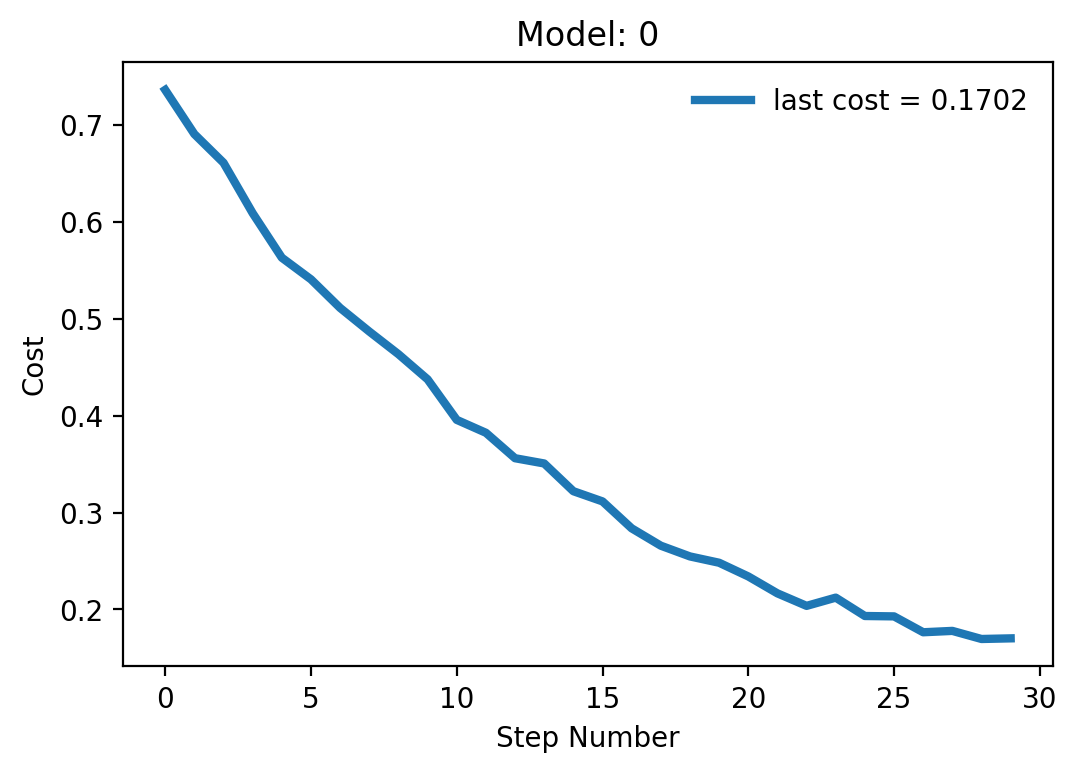

In [ ]:
#adapted from Week4_Autoencoder.ipynb
model =[0] *100#adding an indexing to ease copying and updating model number
j=0#Zeroeth model
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(4,5,input_shape=(None,None,1),
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(9,9),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(9,9))) # up
model[j].add(keras.layers.Conv2D(4,5,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=30
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=1000,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Model: {j}')
ax.legend();# added legend to show last cost

# Task 1
M0. Conv(4,(5,5)) Pool(9,9) Up(9,9) Con(4,(5,5). Last cost = 0.1702


Clearly M0's last cost of 0.1702 is a long way from 0.02 target, but testing approach seemed to be working.
<p>Before woring on architecture, one major thing to decide was number of steps and batchsize. Therefore 3000 steps with 10 batchsize with the same model was tried.


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, None, None, 4)     104       
_________________________________________________________________
average_pooling2d_30 (Averag (None, None, None, 4)     0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, None, None, 1)     37        
_________________________________________________________________
up_sampling2d_31 (UpSampling (None, None, None, 1)     0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, None, None, 4)     104       
_________________________________________________________________
conv2d_114 (Conv2D)          (None, None, None, 1)     37        
Total params: 282
Trainable params: 282
Non-trainable params: 0
_______________________________________________________

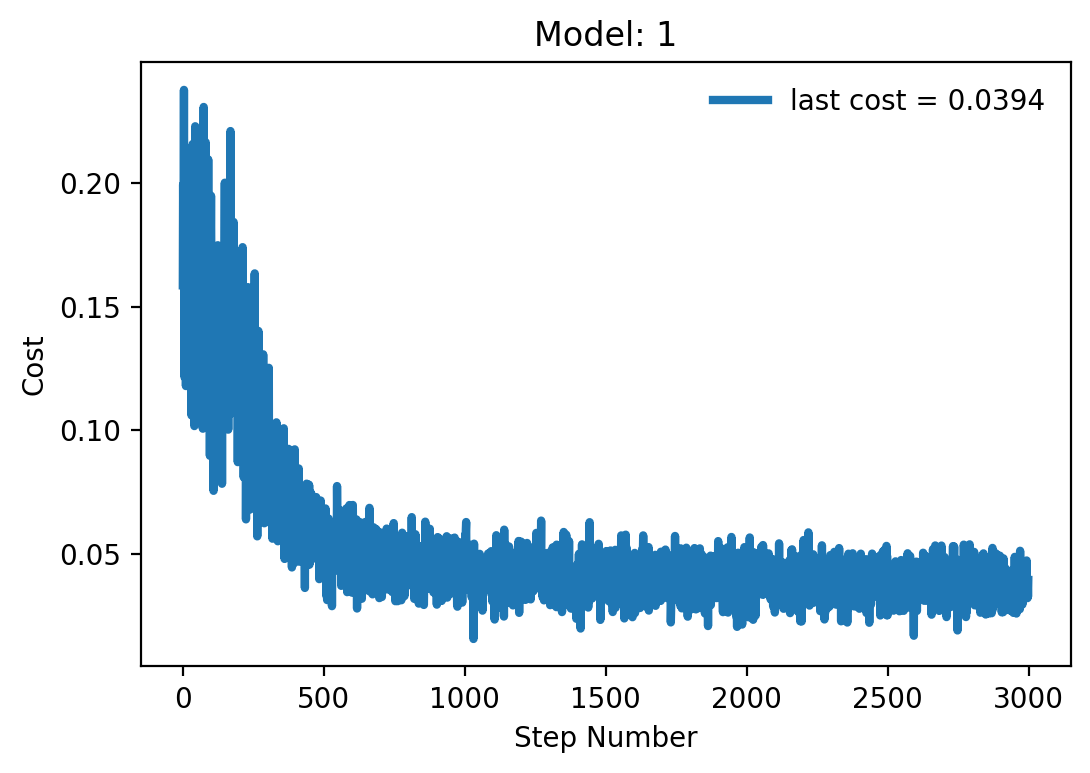

In [ ]:
j=1
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(4,5,input_shape=(None,None,1),
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(9,9),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(9,9))) # up
model[j].add(keras.layers.Conv2D(4,5,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=3000
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=10,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Model: {j}')
ax.legend();# added legend to show last cost

# Task 1
M0. Conv(4,(5,5)) Pool(9,9) Up(9,9) Con(4,(5,5)). Last cost = 0.1702
<p>M1 as above but batchsize = 10. Last cost = 0.0394

There was quite a lot of volatility in cost readings, so 1500 steps and 20 batchsize was considered.

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_115 (Conv2D)          (None, None, None, 4)     104       
_________________________________________________________________
average_pooling2d_31 (Averag (None, None, None, 4)     0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, None, None, 1)     37        
_________________________________________________________________
up_sampling2d_32 (UpSampling (None, None, None, 1)     0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, None, None, 4)     104       
_________________________________________________________________
conv2d_118 (Conv2D)          (None, None, None, 1)     37        
Total params: 282
Trainable params: 282
Non-trainable params: 0
_______________________________________________________

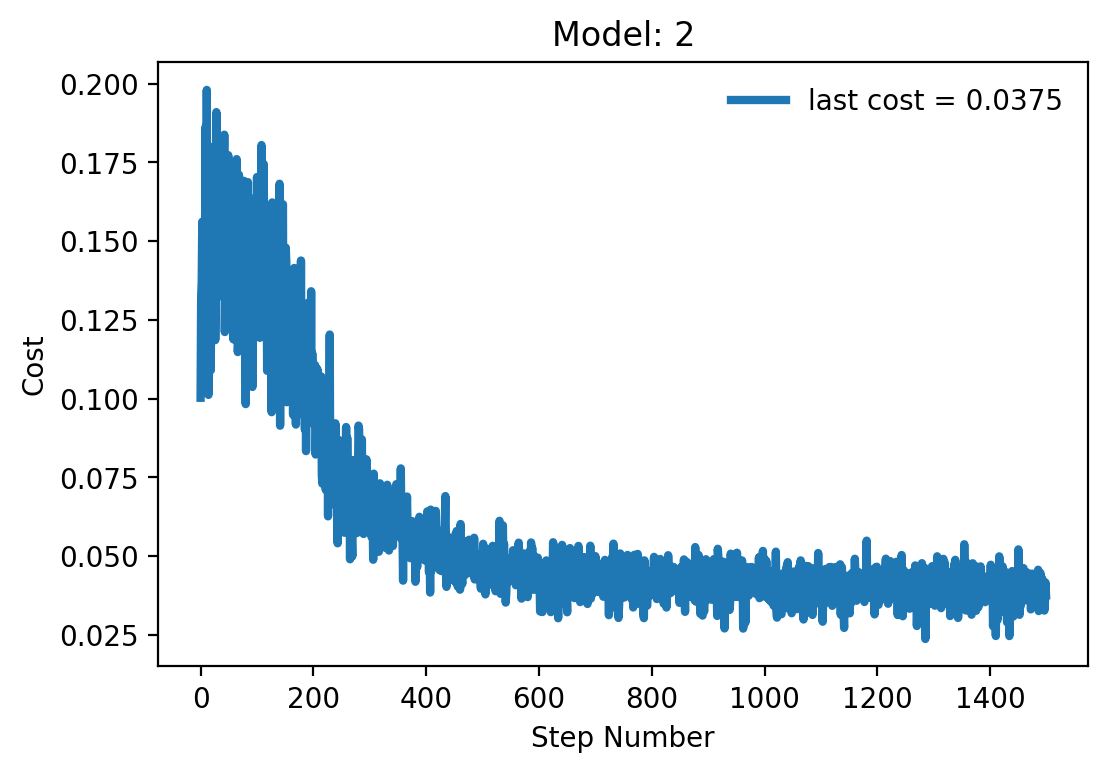

In [ ]:
j=2
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(4,5,input_shape=(None,None,1),
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(9,9),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(9,9))) # up
model[j].add(keras.layers.Conv2D(4,5,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=1500
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=20,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Model: {j}')
ax.legend();# added legend to show last cost

#Task 1
M0. Conv(4,(5,5)) Pool(9,9) Up(9,9) Con(4,(5,5)). Last cost = 0.1702
<p>M1 as above but batchsize = 10. Last cost = 0.0394
<p>M2 as above but batchsize = 20. Last cost = 0.0375
<p>A little better on the volatility front. While it looks likes model converges quite quickly, it is good to have some "space" for training of more complex models. 
<p>Set up in M2 used going forward. Now adding more features in the convolution layers was tried: from 4 to 10.

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_119 (Conv2D)          (None, None, None, 10)    260       
_________________________________________________________________
average_pooling2d_32 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, None, None, 1)     91        
_________________________________________________________________
up_sampling2d_33 (UpSampling (None, None, None, 1)     0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, None, None, 10)    260       
_________________________________________________________________
conv2d_122 (Conv2D)          (None, None, None, 1)     91        
Total params: 702
Trainable params: 702
Non-trainable params: 0
_______________________________________________________

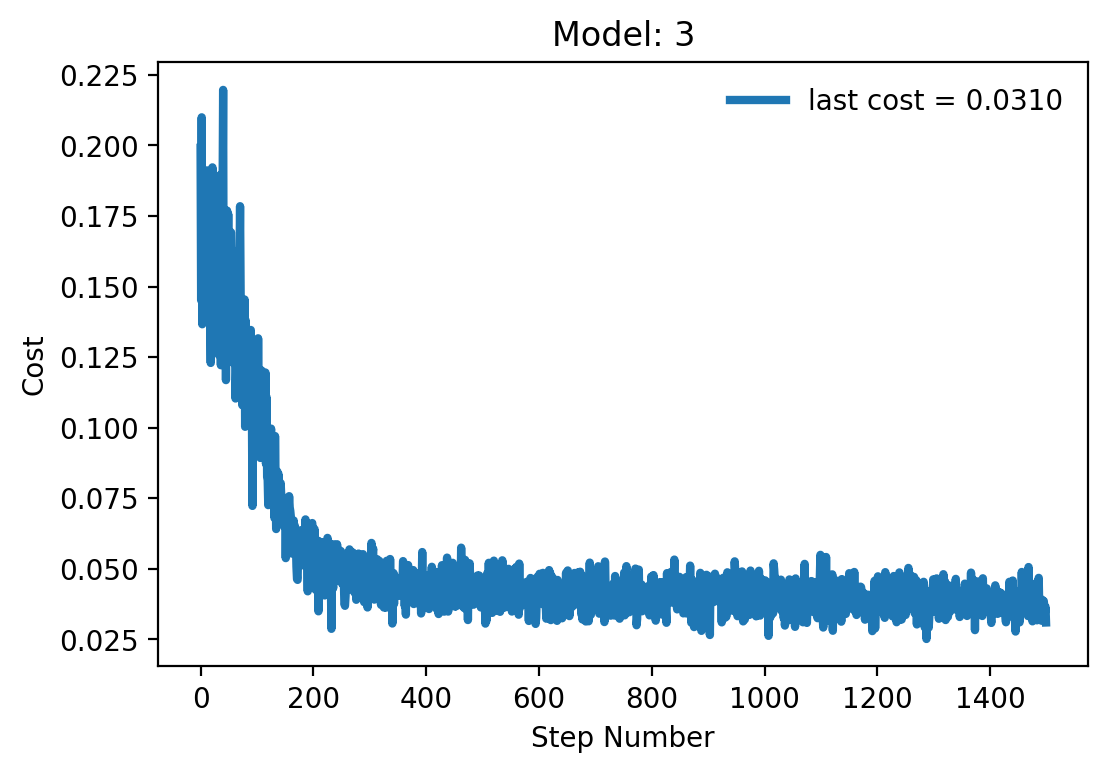

In [ ]:
j=3
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(9,9),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(9,9))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=1500
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=20,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Model: {j}')
ax.legend();# added legend to show last cost

# Task 1

M2. Conv(4,(5,5)) Pool(9,9) Up(9,9) Conv(4,(5,5)). Last cost = 0.0375
<p>M3. Conv(10,(5,5)) Pool(9,9) Up(9,9) Conv(10,(5,5)). Last cost = 0.0310
<p>Decent improvement in the model seen. It was decided not to increase features further, as circle images are simpler than MNIST images. Changing kernal size to (3,3) was tried.

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_123 (Conv2D)          (None, None, None, 10)    100       
_________________________________________________________________
average_pooling2d_33 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, None, None, 1)     91        
_________________________________________________________________
up_sampling2d_34 (UpSampling (None, None, None, 1)     0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, None, None, 10)    100       
_________________________________________________________________
conv2d_126 (Conv2D)          (None, None, None, 1)     91        
Total params: 382
Trainable params: 382
Non-trainable params: 0
_______________________________________________________

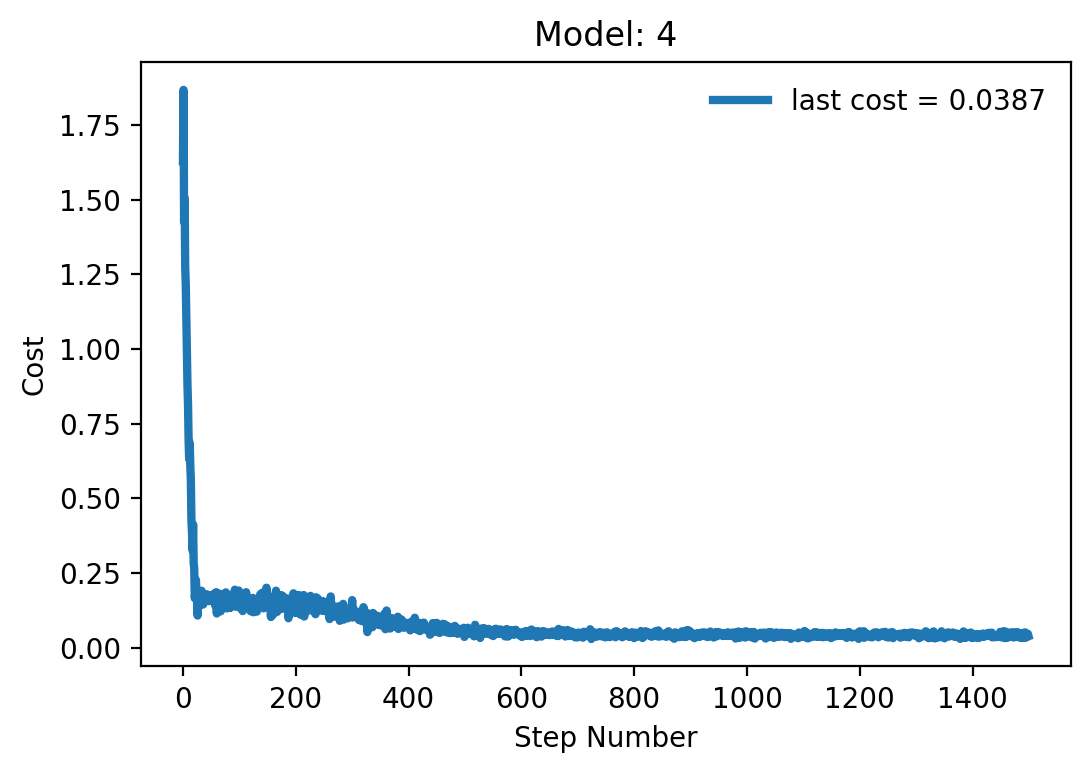

In [ ]:
j=4
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(10,3,input_shape=(None,None,1),
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(9,9),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(9,9))) # up
model[j].add(keras.layers.Conv2D(10,3,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=1500
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=20,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Model: {j}')
ax.legend();# added legend to show last cost

#Task 1
<p>M3. Conv(10,(5,5)) Pool(9,9) Up(9,9) Conv(10,(5,5)). Last cost = 0.0310
<p>M4. Conv(10,(3,3)) Pool(9,9) Up(9,9) Conv(10,(3,3)). Last cost = 0.0387

Performance got worse. Stayed with M3, but Kernal (9,9) was tried.

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_131 (Conv2D)          (None, None, None, 10)    820       
_________________________________________________________________
average_pooling2d_35 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, None, None, 1)     91        
_________________________________________________________________
up_sampling2d_36 (UpSampling (None, None, None, 1)     0         
_________________________________________________________________
conv2d_133 (Conv2D)          (None, None, None, 10)    820       
_________________________________________________________________
conv2d_134 (Conv2D)          (None, None, None, 1)     91        
Total params: 1,822
Trainable params: 1,822
Non-trainable params: 0
___________________________________________________

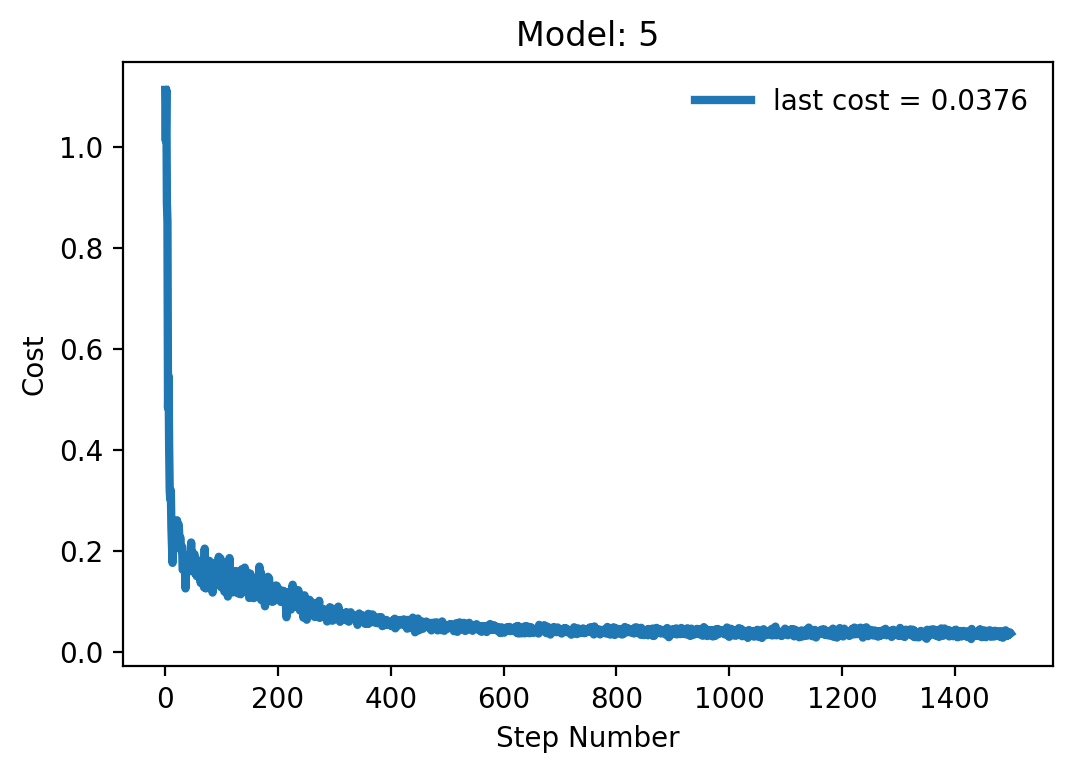

In [ ]:
j=5
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(10,9,input_shape=(None,None,1),
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(9,9),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(9,9))) # up
model[j].add(keras.layers.Conv2D(10,9,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=1500
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=20,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Model: {j}')

ax.legend();# added legend to show last cost

#Task 1
<p>M3. Conv(10,(5,5)) Pool(9,9) Up(9,9) Conv(10,(5,5)). Last cost = 0.0310
<p>M5. Conv(10,(9,9)) Pool(9,9) Up(9,9) Conv(10,(9,9)). Last cost = 0.0376
<p>Got worse so stick with M3, but tried 2 pooling (3,3)/ convolution pairs, mirrored in upscaling.



Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_141 (Conv2D)          (None, None, None, 10)    260       
_________________________________________________________________
average_pooling2d_38 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, None, None, 10)    2510      
_________________________________________________________________
average_pooling2d_39 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, None, None, 1)     91        
_________________________________________________________________
up_sampling2d_39 (UpSampling (None, None, None, 1)     0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, None, None, 10)  

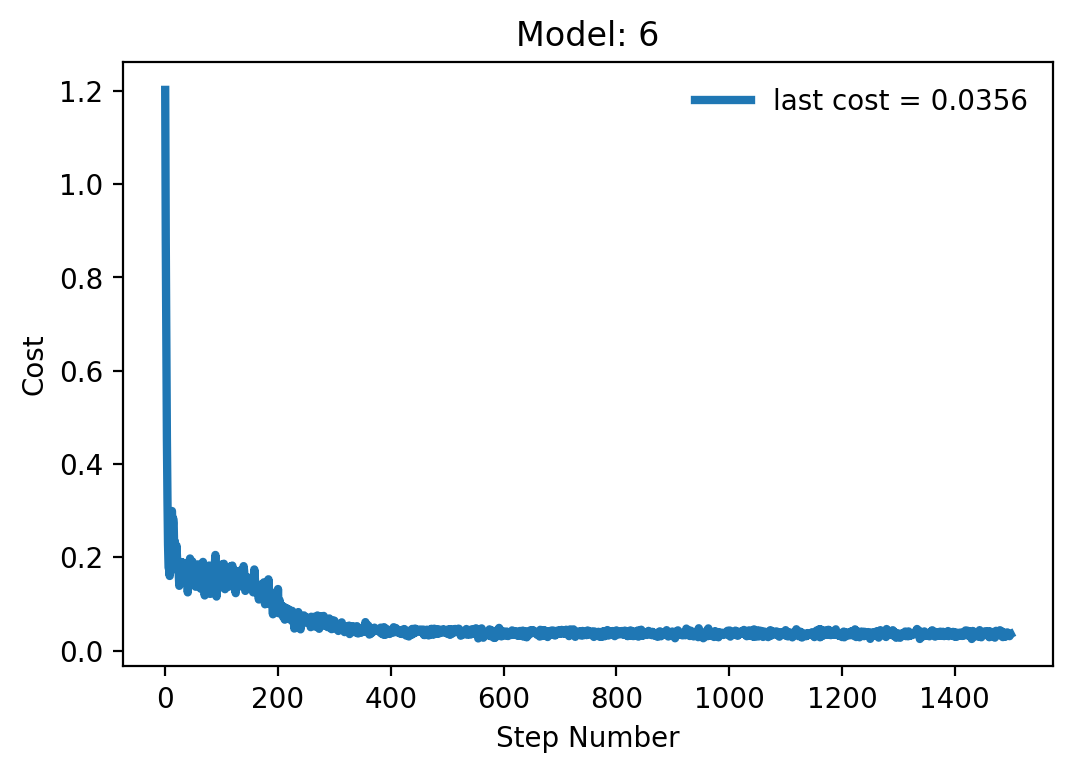

In [ ]:
j=6
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,3))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,3))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=1500
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=20,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Model: {j}')
ax.legend();# added legend to show last cost

#Task 1
<p>M3. Conv(10,(5,5)) Pool(9,9) Up(9,9) Conv(10,(5,5)). Last cost = 0.0310
<p>M6. Conv(10,(5,5)) Pool(3,3) Conv(10,(5,5)) Pool(3,3) Up(3,3) Conv(10,(5,5)) Up(3,3) Conv(10,(5,5)) Last cost = 0.0356
<p>Performance got worse. Tried M6 with relu activations instead of sigmoid.


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_147 (Conv2D)          (None, None, None, 10)    260       
_________________________________________________________________
average_pooling2d_40 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_148 (Conv2D)          (None, None, None, 10)    2510      
_________________________________________________________________
average_pooling2d_41 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, None, None, 1)     91        
_________________________________________________________________
up_sampling2d_41 (UpSampling (None, None, None, 1)     0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, None, None, 10)  

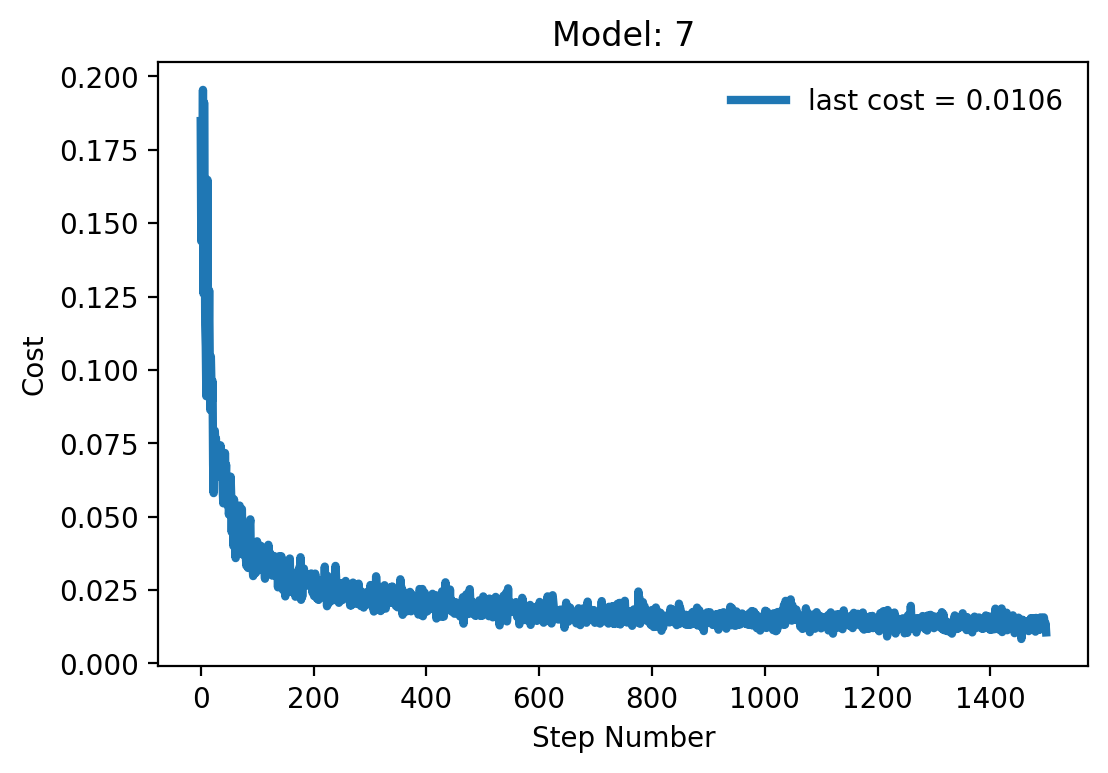

In [ ]:
j=7
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,3))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,3))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=1500
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=20,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Model: {j}')
ax.legend();# added legend to show last cost

<p>M3. Conv(10,(5,5)) Pool(9,9) Up(9,9) Conv(10,(5,5)). Last cost = 0.0310
<p>M6. Conv(10,(5,5)) Pool(3,3) Conv(10,(5,5)) Pool(3,3) Up(3,3) Conv(10,(5,5)) Up(3,3) Conv(10,(5,5)) Last cost = 0.0356
<p>M7. as above with relu instead of sigmoid. Last cost = 0.0106
<p>A massive improvement using the relu function and well under the target set of 0.02. Wish this had been tried earlier!
<p>It was decided to test to see if target could be achieved with one pooling/ convolution pair and one upscaling/convolutional pair, i.e. M3 with relu replacing sigmoid.

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_153 (Conv2D)          (None, None, None, 10)    260       
_________________________________________________________________
average_pooling2d_42 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_154 (Conv2D)          (None, None, None, 1)     91        
_________________________________________________________________
up_sampling2d_43 (UpSampling (None, None, None, 1)     0         
_________________________________________________________________
conv2d_155 (Conv2D)          (None, None, None, 10)    260       
_________________________________________________________________
conv2d_156 (Conv2D)          (None, None, None, 1)     91        
Total params: 702
Trainable params: 702
Non-trainable params: 0
_______________________________________________________

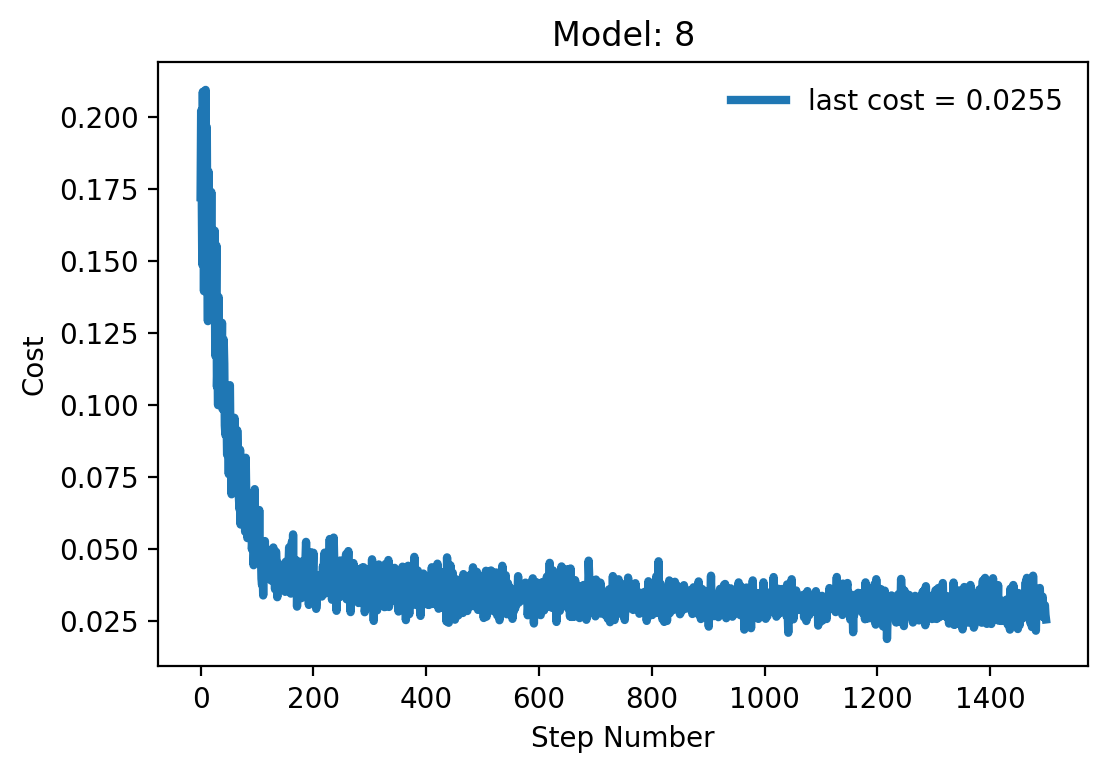

In [ ]:
j=8
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(9,9),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(9,9))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=1500
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=20,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Model: {j}')
ax.legend();# added legend to show last cost

#Task 1
<p>M3. Conv(10,(5,5)) Pool(9,9) Up(9,9) Conv(10,(5,5)). Last cost = 0.0310
<p>M6. Conv(10,(5,5)) Pool(3,3) Conv(10,(5,5)) Pool(3,3) Up(3,3) Conv(10,(5,5)) Up(3,3) Conv(10,(5,5)) Last cost = 0.0356
<p>M7. as M6 with relu instead of sigmoid. Last cost = 0.0106
<p>M8. as M3 bur relu instead of sigmoid. Last cost = 0.0255

M8 does improve on M3, so relu looks like the right choice. It does not meet the target, though, unlike M7. Therefore M7 remained the selected model. It was a little concerning the volatility seen in the cost function and maybe M7 has been lucky with the last cost measure. It was decide to verify with a large batchsizer and fewer steps.

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_163 (Conv2D)          (None, None, None, 10)    260       
_________________________________________________________________
average_pooling2d_45 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, None, None, 10)    2510      
_________________________________________________________________
average_pooling2d_46 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_165 (Conv2D)          (None, None, None, 1)     91        
_________________________________________________________________
up_sampling2d_46 (UpSampling (None, None, None, 1)     0         
_________________________________________________________________
conv2d_166 (Conv2D)          (None, None, None, 10)  

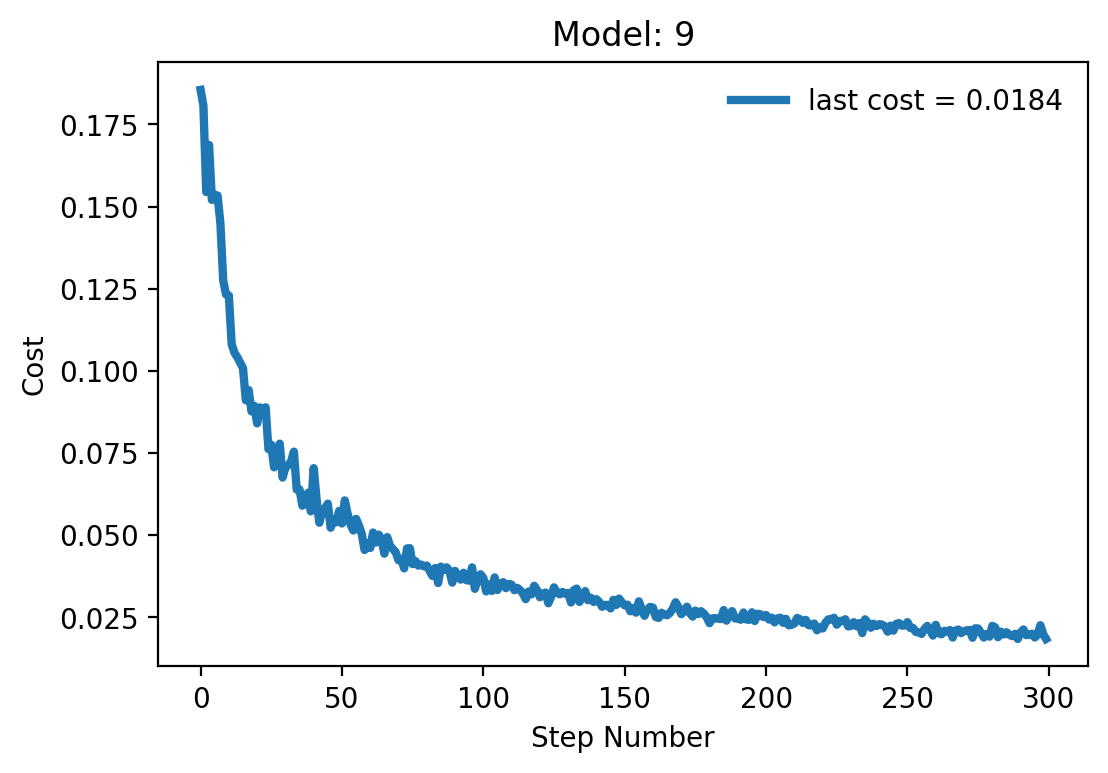

In [ ]:
j=9
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,3))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,3))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=300
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=100,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Model: {j}')
ax.legend();# added legend to show last cost

# Task 1
<p>M7. Last cost = 0.0106
<p>M8. Last cost = 0.0184

So, yes, some variation is seen when number of steps was reduced, but it still produced a cost below target.

#Task 1 Conclusions
Model 7, produced a last cost of 0.0106, well below target. More testing by running it again and again and averaging should be done to obtain the precise value, due to the randomness included in the testing.
<p>Large improvements were made by tweaking the batchsize/ steps and by moving to the relu function. It seems that moving to two pooling/ convolution layers and consequent two upscaling/ convolution pairs was necessary to achieve the target of 0.02. Further optimisation could be attempted in many ways: features, kernals, more convolution and pooling layers. Time did not permit.

#Task 2
Only 3 neurons are allowed in the inner layer and no target cost was set. Clearly costs will be much higher than for nine neurons, because of the tight bottleneck. M7 was adapted to provide a three neuron inner layer in following way:
<p>Image starts at (27,27)
<p>First pooling reduces by (3,3) factor to (9,9) "image"
<p>Second pooling reduces by (3,9) factor to (3,1) "image"
<p>Upscaling is then done in two stages to mirror this to take back to (27,27) "image"

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, None, None, 10)    260       
_________________________________________________________________
average_pooling2d_2 (Average (None, None, None, 10)    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 10)    2510      
_________________________________________________________________
average_pooling2d_3 (Average (None, None, None, 10)    0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 1)     91        
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, None, None, 1)     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 10)   

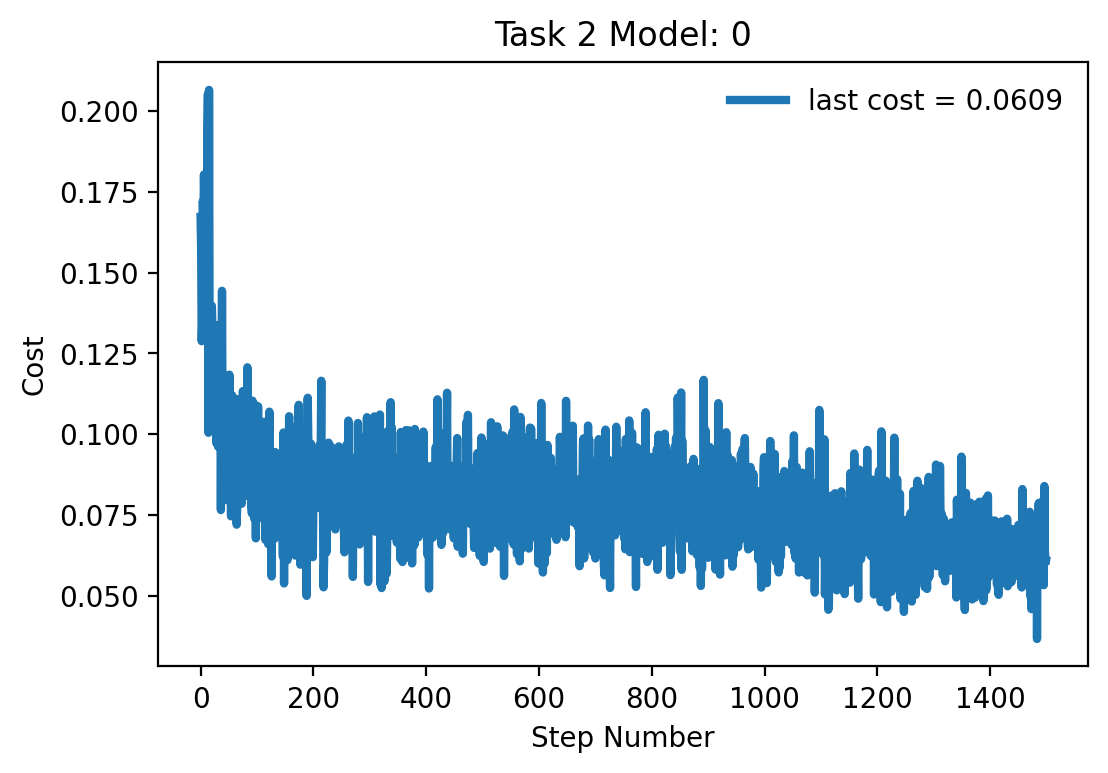

In [ ]:
model =[0] *100#adding an indexing to ease copying and updating model number
j=0#Zeroeth model
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,9),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,9))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,3))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=1500
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=20,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Task 2 Model: {j}')
ax.legend();# added legend to show last cost

# Task 2
M0. last cost = 0.0609 
<p>A surprisingly good result as the bottleneck is only three neurons wide.
<p>Replacing relu with sigmoid was tried.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, None, None, 10)    260       
_________________________________________________________________
average_pooling2d_5 (Average (None, None, None, 10)    0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, None, None, 10)    2510      
_________________________________________________________________
average_pooling2d_6 (Average (None, None, None, 10)    0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, None, None, 1)     91        
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, None, None, 1)     0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, None, 10)   

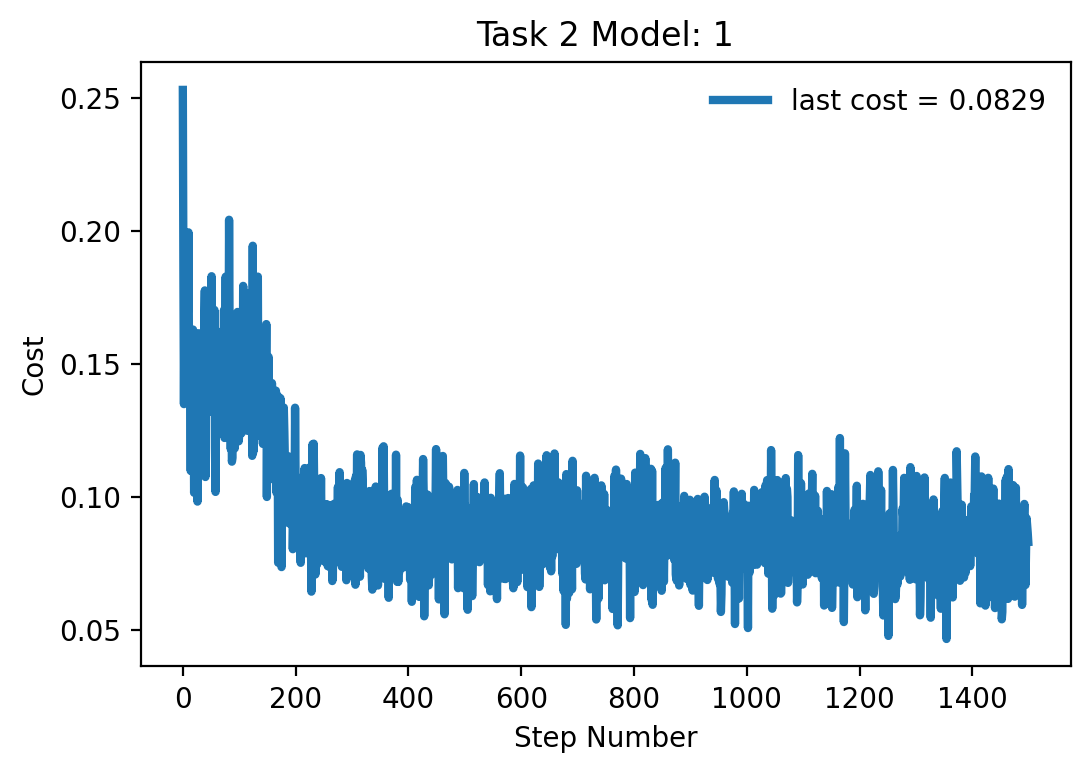

In [ ]:

j=1
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,9),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,9))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,3))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="sigmoid",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=1500
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=20,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Task 2 Model: {j}')
ax.legend();# added legend to show last cost

# Task 2
M0. last cost = 0.0609
<p>M1. last cost = 0.0829
<p>Stick with relu function and M0. Tried to increase batch size to 100 and thus decrease steps to 300 as significant volatility seen in cost function.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, None, None, 10)    260       
_________________________________________________________________
average_pooling2d_9 (Average (None, None, None, 10)    0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, None, None, 10)    2510      
_________________________________________________________________
average_pooling2d_10 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, None, None, 1)     91        
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, None, None, 1)     0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, None, None, 10)   

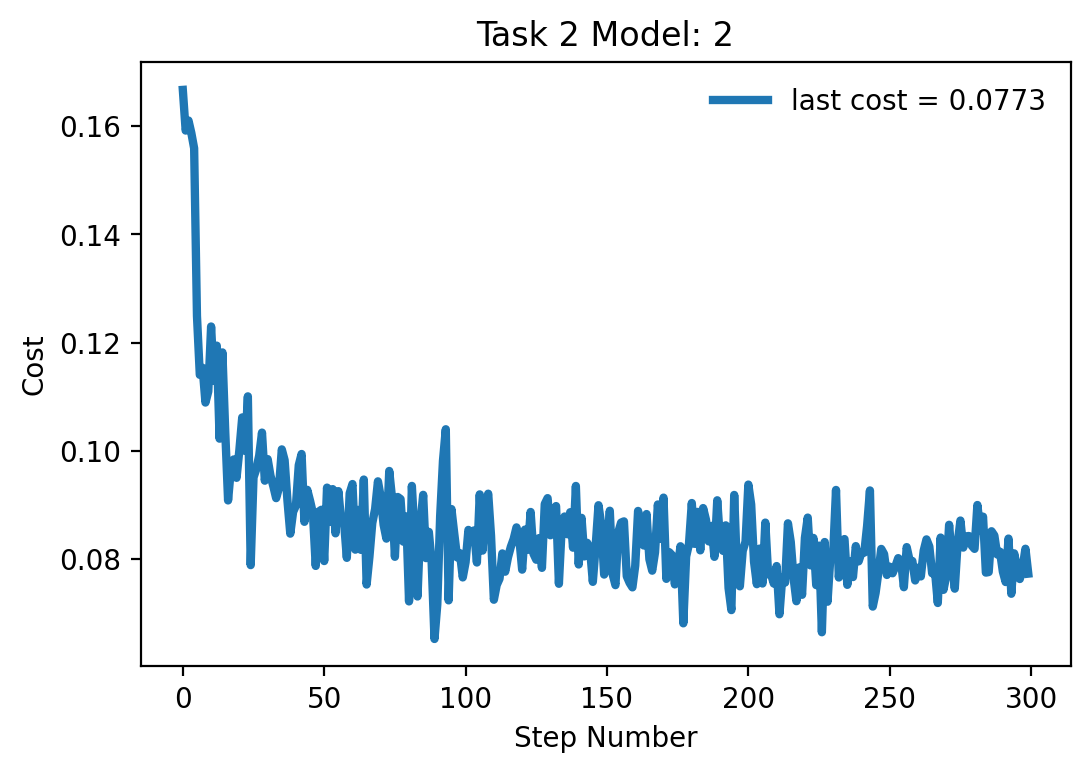

In [ ]:
j=2
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,9),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,9))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,3))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=300
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=100,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Task 2 Model: {j}')
ax.legend();# added legend to show last cost

#Task 2
M0. last cost = 0.0609
<p>M2. last cost = 0.0773
<p>Lower volatility in cost function, so selected M2. 
<p>Try the extreme where image goes from (27,27) to (27,9) to (9,9) to (3,9) to (3,3) to (3,1) and back again.

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, None, None, 10)    260       
_________________________________________________________________
average_pooling2d_11 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, None, None, 10)    2510      
_________________________________________________________________
average_pooling2d_12 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, None, None, 10)    2510      
_________________________________________________________________
average_pooling2d_13 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, None, None, 10)   

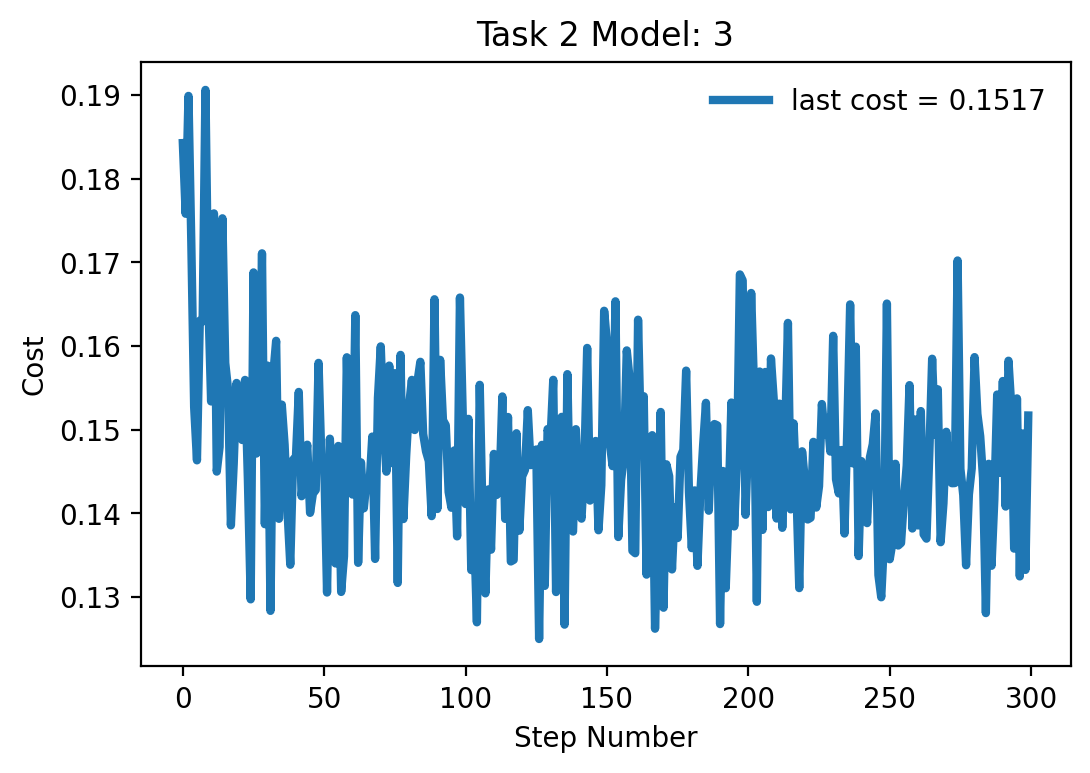

In [ ]:
j=3
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,1),padding='same')) # down
model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(1,3),padding='same')) # down
model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,1),padding='same')) # down
model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(1,3),padding='same')) # down
model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(1,3),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(1,3))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(1,3))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,1))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(1,3))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,1))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=300
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=100,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Task 2 Model: {j}')
ax.legend();# added legend to show last cost


# Task 2
M2. last cost = 0.0773
<p>M3. last cost = 0.1517
Disappointingly (given how long it took to construct).
<p>Instead, now a simpler model than M2 was constructed with just one pool and one upscaling later.

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, None, None, 10)    260       
_________________________________________________________________
average_pooling2d_16 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, None, None, 1)     91        
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, None, None, 1)     0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, None, None, 10)    260       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, None, None, 1)     91        
Total params: 702
Trainable params: 702
Non-trainable params: 0
________________________________________________________

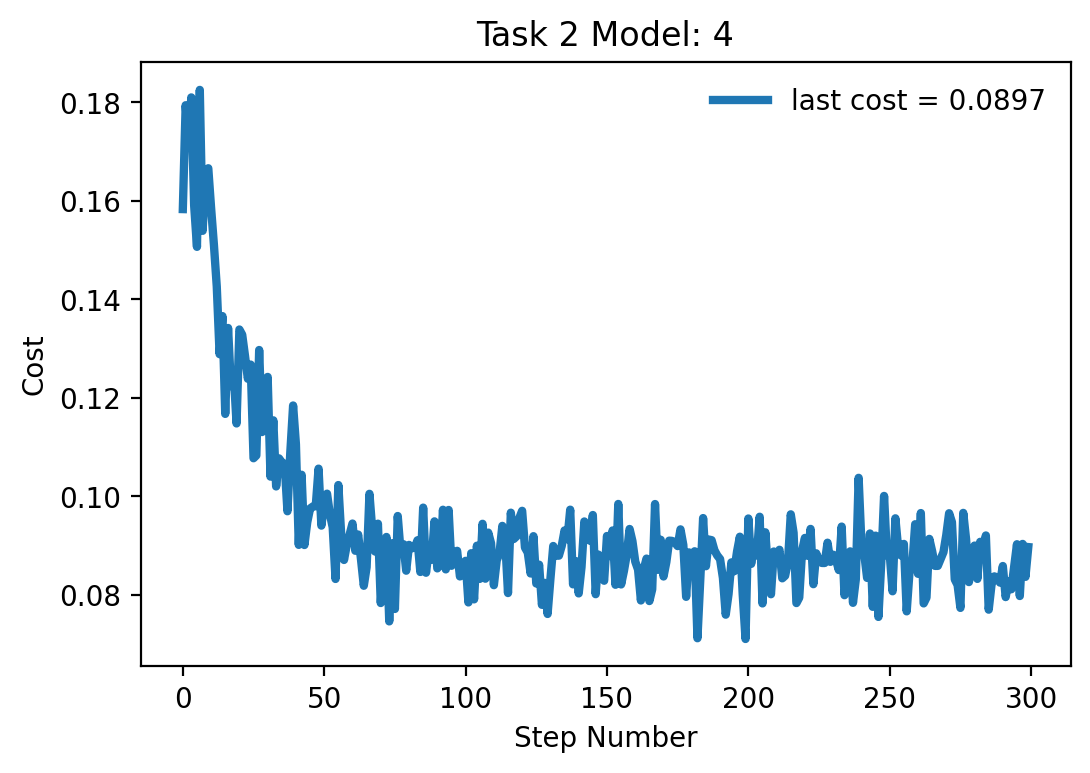

In [ ]:
j=4
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(9,27),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(9,27))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=300
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=100,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Task 2 Model: {j}')
ax.legend();# added legend to show last cost

# Task 2
<p>M2. last cost = 0.0773
<p>M4. last cost = 0.0897
The very simple M4 model, performed quite well, much better than complex M3, but a little behind M2.
<p>M2 remains selected. It is a two pooling layer model. Now the order of the pooling scales were reversed from (3,3) then (3,9) to (3,9) then (3,3). This reverse was mirrored in the upscaling layers.


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, None, None, 10)    260       
_________________________________________________________________
average_pooling2d_18 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, None, None, 10)    2510      
_________________________________________________________________
average_pooling2d_19 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, None, None, 1)     91        
_________________________________________________________________
up_sampling2d_18 (UpSampling (None, None, None, 1)     0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, None, None, 10)   

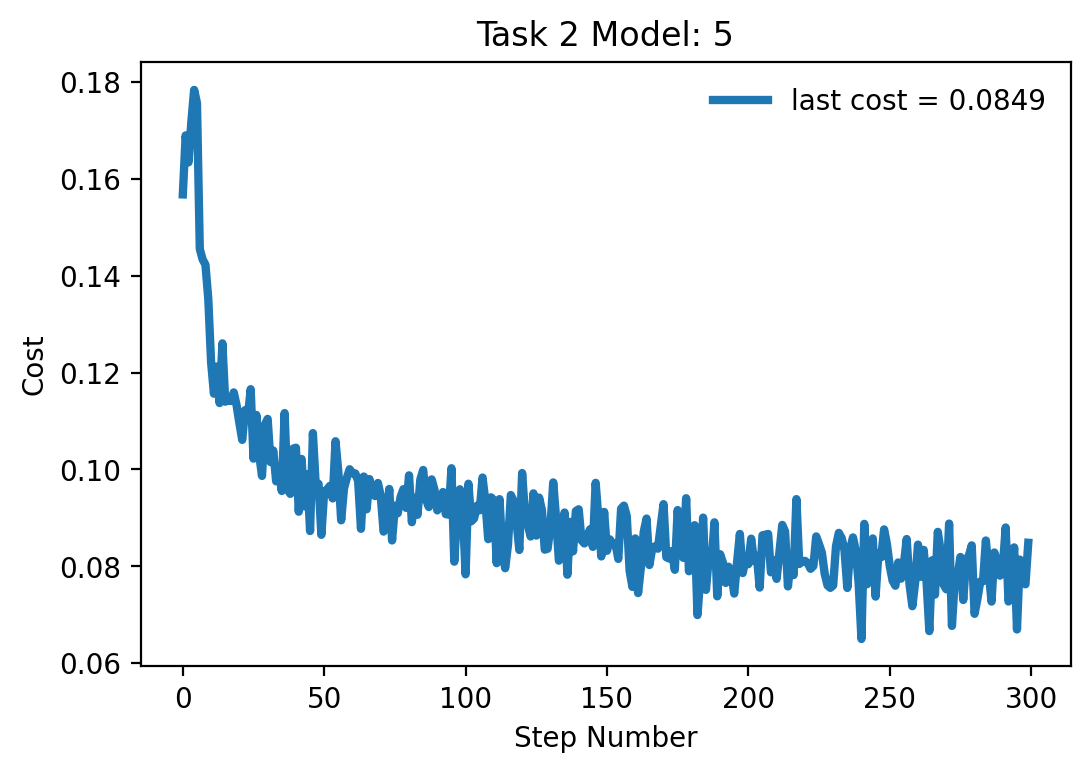

In [ ]:
j=5
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,9),padding='same')) # down
model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,3))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,9))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=300
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=100,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Task 2 Model: {j}')
ax.legend();# added legend to show last cost

# Task 2
M2. last cost = 0.0773
<p>M5. last cost = 0.0849

M2 remained the selected model. Now batch normalisation was applied after each relu activation.

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, None, None, 10)    260       
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 10)    40        
_________________________________________________________________
average_pooling2d_20 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, None, None, 10)    2510      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 10)    40        
_________________________________________________________________
average_pooling2d_21 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, None, None, 1)   

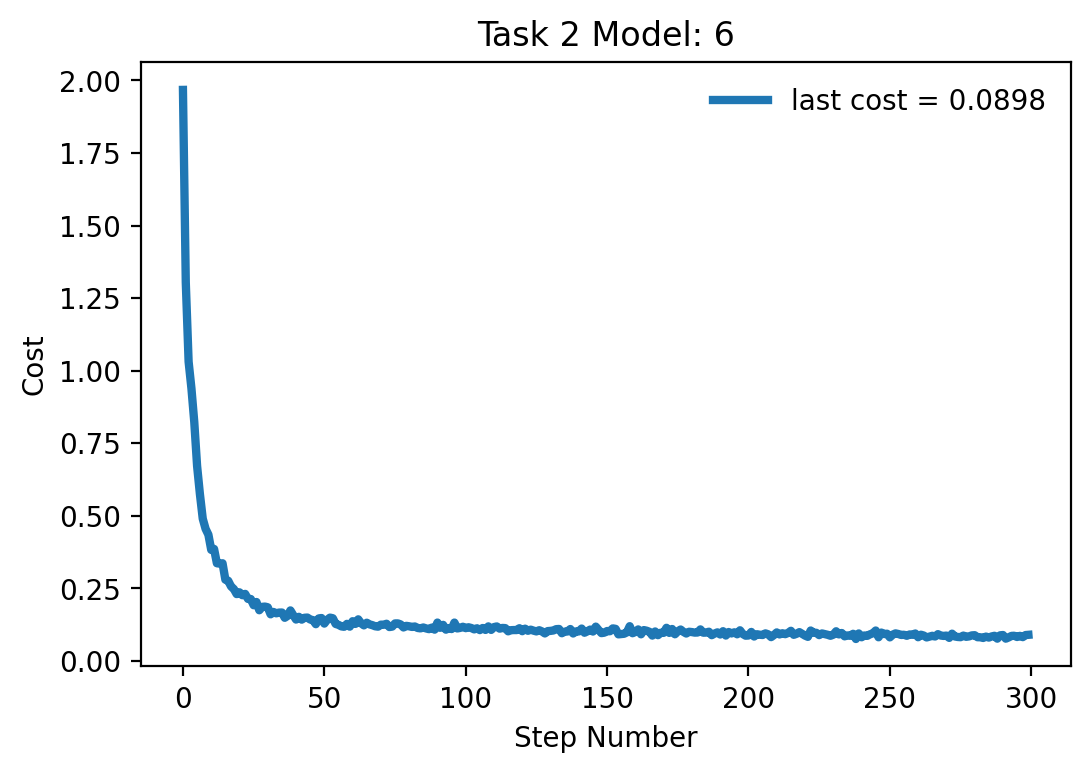

In [ ]:

j=6
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.BatchNormalization())
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model[j].add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.BatchNormalization())
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,9),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="relu",padding='same'))
model[j].add(keras.layers.BatchNormalization())
model[j].add(keras.layers.UpSampling2D(size=(3,9))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.BatchNormalization())
model[j].add(keras.layers.UpSampling2D(size=(3,3))) # up
model[j].add(keras.layers.Conv2D(10,5,
               activation="relu",padding='same'))
model[j].add(keras.layers.BatchNormalization())

model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=300
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=100,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Task 2 Model: {j}')
ax.legend();# added legend to show last cost


# Task 2
M2. last cost = 0.0773
<p>M6. last cost = 0.0898

M2 remained the selected model, but batch normalisation did have an enormous effect on the volatility of the cost function.

Now, expanding each convolution layers from (5,5) into two of (3,3) was tried.

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, None, None, 10)    100       
_________________________________________________________________
conv2d_68 (Conv2D)           (None, None, None, 10)    910       
_________________________________________________________________
average_pooling2d_22 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, None, None, 10)    910       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, None, None, 10)    910       
_________________________________________________________________
average_pooling2d_23 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, None, None, 1)   

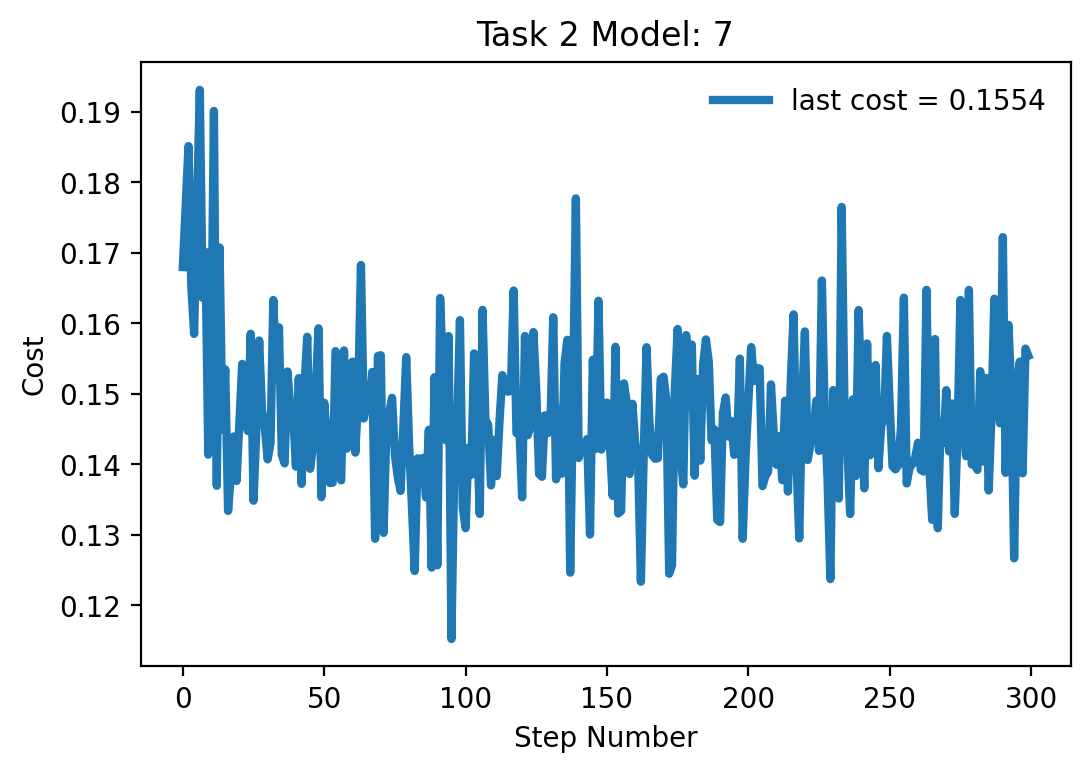

In [ ]:
j=7
model[j]=keras.models.Sequential()

model[j].add(keras.layers.Conv2D(10,3,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.Conv2D(10,3,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model[j].add(keras.layers.Conv2D(10,3,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.Conv2D(10,3,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.AveragePooling2D(pool_size=(3,9),padding='same')) # down
model[j].add(keras.layers.Conv2D(1,3,
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,9))) # up
model[j].add(keras.layers.Conv2D(10,3,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.Conv2D(10,3,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.UpSampling2D(size=(3,3))) # up
model[j].add(keras.layers.Conv2D(10,3,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.Conv2D(10,3,input_shape=(None,None,1),
               activation="relu",padding='same'))
model[j].add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))
model[j].compile(loss='mean_squared_error',
              optimizer='adam')
model[j].summary()

steps=300
cost,y_target=generate_and_train(model[j],circle_generator,img_size=27,batchsize=100,steps=steps)
print_layers(model[j],y_target)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3, label = f'last cost = {cost[-1]:.4f}')#added legend label to show last cost
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title(f'Task 2 Model: {j}')
ax.legend();# added legend to show last cost

# Task 2
M2. last cost = 0.0773

M7. last cost = 0.1554

M2 remained the selected model. It seems that adding too much complexity into the encoder/ decoder actually decreases performance. 

#Task 2 Conclusions
The best model, M2 gave a last cost statistic of 0.0773. It was surprising to me that such a low cost could be acheived through a bottleneck of just three neurons. M2 had an encoder with two pooling layers and two upscaling layers. A model with just one pooling and one upscaling layers (M4) produced a worse (but still decent) result of 0.0897. On the other extreme, a very complex model (M3) with five pooling and five upscaling layers produced a poor result of 0.1517. Furthermore, attempts at spliting each convolution layer into two (M7) also yielded a worse result of 0.1554. It seemed that adding too much complexity was hindering the autoencoder.

As for Task 1, runs should be repeated and averaged to get more precise values for cost. Use of batch normalisation might be helpful in controlling the relu function and this was seen clearly in M6, although it's last cost statistic was inferior (0.0898).

Again, as for Task 1, further optimisation could be attempted in many ways: features, kernals, etc. Time did not permit.
